# **Image Binary Classification using CNN: Part II**
In this section, we modify the dataset treatment compared to the first part. The new training set consists of the first $160$ images, plus $5$ additional images (based on the last digit of my Student ID $116480368$). The remaining images from the original training set are assigned to the new test set. Since there are $209$ images in the original training set, the remaining $44$ images will be used as the test set. The original test dataset is discarded and is no longer used in this part. The model developed in the first part is retrained using this modified dataset, and the results, including both training and test accuracies, are reported. Additionally, we display the indices of all misclassified images in the test set and visualize a selection of these incorrect predictions for further examination.

In [22]:
# Import necessary libraries
from google.colab import drive
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt

In [24]:
# Mount Google Drive to access files stored there
drive.mount('/content/drive')

# Load the training and testing HDF5 files from Google Drive
train_file = h5py.File('/content/drive/My Drive/Colab Notebooks/train_catvnoncat.h5', 'r')

# Extract image data and labels from the HDF5 files
train_images = np.array(train_file['train_set_x']) / 255.0  # Normalize pixel values to range [0, 1]
train_labels = np.array(train_file['train_set_y'])

# Close the HDF5 files after data extraction
train_file.close()

# Convert the data to PyTorch tensors
# Images need to be permuted to match PyTorch's [N, C, H, W] format (N: batch size, C: channels, H: height, W: width)
train_images = torch.tensor(train_images, dtype=torch.float32).permute(0, 3, 1, 2)  # [N, C, H, W]
train_labels = torch.tensor(train_labels, dtype=torch.long)

# Create DataLoader objects for batching the data during training and testing
train_dataset = TensorDataset(train_images, train_labels)  # Combine images and labels into a dataset

# Splitting the dataset
new_train_images = train_images[:165]
new_train_labels = train_labels[:165]

new_test_images = train_images[165:]
new_test_labels = train_labels[165:]

# Set up DataLoaders to handle batching, shuffling for training, and no shuffling for testing
new_train_dataset = TensorDataset(new_train_images, new_train_labels)
new_test_dataset = TensorDataset(new_test_images, new_test_labels)

new_train_loader = DataLoader(new_train_dataset, batch_size=32, shuffle=True)
new_test_loader = DataLoader(new_test_dataset, batch_size=32, shuffle=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Model of CNN**

In this section, we continue using the same CNN model from Part I.

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class CatVsNonCatCNN(nn.Module):
    def __init__(self):
        super(CatVsNonCatCNN, self).__init__()

        # Convolutional layers: These layers learn spatial hierarchies from the images
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # 3 input channels (RGB), 16 output channels
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # 16 input channels, 32 output channels
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 32 input channels, 64 output channels

        # Initialize fully connected (fc) layer dimensions based on the output of the convolutions
        self._initialize_fc()

        # Fully connected layers: These layers make predictions based on learned features
        self.fc1 = nn.Linear(self.flatten_size, 128)  # Input size is calculated in _initialize_fc()
        self.fc2 = nn.Linear(128, 1)  # Output layer for binary classification (1 output unit)

    def _initialize_fc(self):
        # Create a dummy input tensor to calculate the size of the output from the convolutional layers
        example_input = torch.zeros(1, 3, 64, 64)  # Batch size of 1, 3 channels (RGB), 64x64 image size
        # Pass through the convolutional layers with max pooling to simulate forward pass
        x = F.max_pool2d(F.relu(self.conv1(example_input)), 2, 2)  # First convolution, then max pooling
        x = F.max_pool2d(F.relu(self.conv2(x)), 2, 2)  # Second convolution, then max pooling
        x = F.max_pool2d(F.relu(self.conv3(x)), 2, 2)  # Third convolution, then max pooling
        # Calculate the flattened size after the convolutions and pooling
        self.flatten_size = x.numel()  # Number of elements in the tensor

    def forward(self, x):
        # Forward pass through the convolutional layers and max pooling layers
        x = F.relu(self.conv1(x))  # Apply ReLU activation to first convolution
        x = F.max_pool2d(x, 2, 2)  # Max pooling to reduce dimensionality
        x = F.relu(self.conv2(x))  # Apply ReLU activation to second convolution
        x = F.max_pool2d(x, 2, 2)  # Max pooling to reduce dimensionality
        x = F.relu(self.conv3(x))  # Apply ReLU activation to third convolution
        x = F.max_pool2d(x, 2, 2)  # Max pooling to reduce dimensionality
        # Flatten the tensor for input into fully connected layers
        x = x.view(x.size(0), -1)  # Flatten the output (preserving the batch size)
        # Forward pass through fully connected layers
        x = F.relu(self.fc1(x))  # Apply ReLU activation to first fully connected layer
        x = torch.sigmoid(self.fc2(x))  # Sigmoid activation for binary classification output
        return x  # Output probabilities for the binary classification


**Re-training the Model**

We now retrain the CNN model with the new training dataset. All the model parameters remain the same, except for the number of epochs which has been increased by 30.

In [26]:
# Set the device to use CPU
device = torch.device('cpu')

# Initialize the model, move it to the appropriate device (GPU/CPU)
model = CatVsNonCatCNN().to(device)

# Define the loss function: Binary Cross-Entropy (BCELoss) for binary classification
criterion = nn.BCELoss()

# Initialize the optimizer: Adam optimizer with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the number of epochs for training
epochs = 100

# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0  # Track the loss for the current epoch

    # Iterate through the training dataset in batches
    for images, labels in new_train_loader:
        images, labels = images.to(device), labels.to(device).float()  # Move data to the device (GPU/CPU)

        # Forward pass: Compute predicted outputs by passing images through the model
        outputs = model(images).squeeze()  # Remove extra dimensions and get predictions
        loss = criterion(outputs, labels)  # Calculate the loss between predictions and true labels

        # Backward pass: Compute gradients for model parameters
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute the gradient of the loss
        optimizer.step()  # Update model parameters using the computed gradients

        # Accumulate the loss for the current batch
        running_loss += loss.item()

    # Print the average loss for the current epoch
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(new_train_loader):.4f}")


Epoch 1/100, Loss: 0.6871
Epoch 2/100, Loss: 0.6451
Epoch 3/100, Loss: 0.6168
Epoch 4/100, Loss: 0.5939
Epoch 5/100, Loss: 0.5519
Epoch 6/100, Loss: 0.5388
Epoch 7/100, Loss: 0.4969
Epoch 8/100, Loss: 0.4931
Epoch 9/100, Loss: 0.4242
Epoch 10/100, Loss: 0.4110
Epoch 11/100, Loss: 0.4088
Epoch 12/100, Loss: 0.3732
Epoch 13/100, Loss: 0.3122
Epoch 14/100, Loss: 0.3361
Epoch 15/100, Loss: 0.2973
Epoch 16/100, Loss: 0.3882
Epoch 17/100, Loss: 0.2876
Epoch 18/100, Loss: 0.2509
Epoch 19/100, Loss: 0.2373
Epoch 20/100, Loss: 0.2339
Epoch 21/100, Loss: 0.3050
Epoch 22/100, Loss: 0.2213
Epoch 23/100, Loss: 0.2240
Epoch 24/100, Loss: 0.1924
Epoch 25/100, Loss: 0.1660
Epoch 26/100, Loss: 0.1612
Epoch 27/100, Loss: 0.1700
Epoch 28/100, Loss: 0.1663
Epoch 29/100, Loss: 0.1310
Epoch 30/100, Loss: 0.1415
Epoch 31/100, Loss: 0.1898
Epoch 32/100, Loss: 0.1841
Epoch 33/100, Loss: 0.1538
Epoch 34/100, Loss: 0.1426
Epoch 35/100, Loss: 0.1585
Epoch 36/100, Loss: 0.1197
Epoch 37/100, Loss: 0.1174
Epoch 38/1

# **Accuracy in Training Data Set**

After retraining the CNN model, the accuracy of the model for the training data is shown. The results show that the method classifies these images with $100\%$ accuracy.

In [27]:
# Set the model to evaluation mode (disable dropout, batch normalization, etc.)
model.eval()

# Initialize counters to track correct predictions and total samples in the training set
correct_train = 0  # Number of correct predictions
total_train = 0    # Total number of training samples

# Disable gradient calculations during evaluation to save memory and computational resources
with torch.no_grad():
    # Iterate over the new training dataset using the DataLoader
    for images, labels in new_train_loader:
        # Move images and labels to the appropriate device (GPU/CPU)
        images, labels = images.to(device), labels.to(device)

        # Perform forward pass: Compute model outputs
        outputs = model(images).squeeze()  # Remove unnecessary dimensions from the output tensor

        # Apply a threshold to convert probabilities into binary predictions
        predictions = (outputs > 0.5).long()  # Binary classification: Threshold at 0.5

        # Update the count of correct predictions
        correct_train += (predictions == labels).sum().item()

        # Update the total number of samples processed
        total_train += labels.size(0)

# Calculate the accuracy on the training set
train_accuracy = 100 * correct_train / total_train

# Print the training accuracy
print(f"Training Accuracy: {train_accuracy:.2f}%")


Training Accuracy: 100.00%


# **Accuracy in Testing Data Set and Misclassified Images**

Now, the performance of the model classifying images from the test set (the remaining 44 images) is shown.

Additionally, we display the indeces of those images wich are misclassify for futher examination.


In [28]:
# Set the model to evaluation mode (turn off dropout, batch normalization, etc.)
model.eval()

# Initialize variables to track correct predictions and total samples
correct = 0
total = 0

# Initialize lists to store information about incorrect predictions
incorrect_indices = []  # List to store indices of incorrect predictions
incorrect_images = []   # List to store images of incorrect predictions
incorrect_labels = []   # List to store true labels of incorrect predictions
incorrect_preds = []    # List to store predicted labels of incorrect predictions

# Disable gradient calculations for inference to save memory and computations
with torch.no_grad():
    # Iterate through the test dataset in batches
    for idx, (images, labels) in enumerate(new_test_loader):
        # Move images and labels to the appropriate device (GPU/CPU)
        images, labels = images.to(device), labels.to(device)

        # Perform forward pass: Compute model outputs
        outputs = model(images).squeeze()  # Remove extra dimensions from the output tensor

        # Convert the outputs to binary predictions (using threshold 0.2)
        predictions = (outputs > 0.2).long()  # Sigmoid output thresholding for binary classification

        # Count correct predictions
        correct += (predictions == labels).sum().item()
        # Count total samples processed
        total += labels.size(0)


        # Identify mismatches (incorrect predictions)
        mismatches = (predictions != labels).cpu().numpy()  # Compare predictions with true labels
        batch_indices = np.where(mismatches)[0]  # Find indices of mismatched predictions within the batch

        # Store indices, images, labels, and predictions of incorrect cases
        incorrect_indices.extend(batch_indices + idx * new_test_loader.batch_size)  # Adjust indices for the full dataset
        incorrect_images.extend(images[batch_indices].cpu().numpy())  # Store images of incorrect predictions
        incorrect_labels.extend(labels[batch_indices].cpu().numpy())  # Store true labels of incorrect predictions
        incorrect_preds.extend(predictions[batch_indices].cpu().numpy())  # Store predicted labels of incorrect predictions

# Calculate and print the accuracy on the test set
print(f"Accuracy on test set: {100 * correct / total:.2f}%")

# Print the indices of incorrect predictions
print("Indices of incorrect predictions in the test set:", incorrect_indices)

Accuracy on test set: 84.09%
Indices of incorrect predictions in the test set: [14, 20, 22, 27, 32, 40, 42]


**Visualizing Misclassified Cases**

Finally, a visual examination of the misclassified cases was performed. At least four random examples from the set of misclassified images were selected and displayed, along with their true and predicted labels. This step was essential for diagnosing potential issues in the dataset or the model. For instance, some images might have been ambiguous or contained noise, making them challenging for the model to classify accurately.

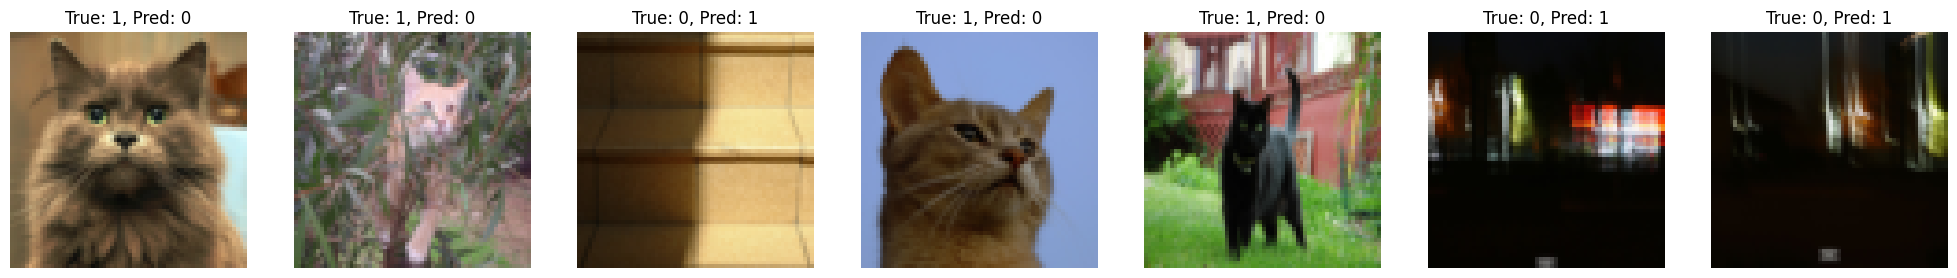

In [29]:


# Visualize a selection of misclassified images
num_to_display = max(4, len(incorrect_images))

# Create a subplot with 1 row and `num_to_display` columns
fig, axs = plt.subplots(1, num_to_display, figsize=(25, 25))

# Loop through the misclassified images
for i in range(num_to_display):
    # Rearrange image dimensions from [Channels, Height, Width] to [Height, Width, Channels]
    image = incorrect_images[i].transpose(1, 2, 0)

    # Extract the true and predicted labels
    true_label = incorrect_labels[i]
    pred_label = incorrect_preds[i]

    # Display the image with the corresponding labels in the title
    axs[i].imshow(image)
    axs[i].set_title(f"True: {true_label}, Pred: {pred_label}")

    # Remove axis ticks for cleaner visualization
    axs[i].axis('off')

# Show the plot
plt.show()
